<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/dev/GNN%20ECG%20timeseries%20prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load libraries

In [1]:
# GraphECGNet with PTB-XL Dataset in Google Colab
!pip install torch torchvision torchaudio
!pip install torch-geometric
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 83.2 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.2 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which

In [7]:
import os
import ast
import pickle
import joblib
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import pandas as pd
import numpy as np
import wfdb
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

Rationale:

Physiological Meaning: Each ECG lead captures electrical activity from a different angle/view of the heart
Spatial Information: Different leads provide complementary information about heart activity
Feature Richness: Each node contains a time series of the ECG signal from that specific lead
Anatomical Relevance: Leads are positioned anatomically around the heart

Limb Lead Connections (0-5):

I ↔ II ↔ III: These leads form Einthoven's triangle
aVR, aVL, aVF: Augmented limb leads connected to the main limb leads
Adjacent leads share similar electrical pathways


Precordial Lead Connections (6-11):

V1 → V2 → V3 → V4 → V5 → V6: Anatomically sequential across the chest
Circular connection (V6 → V1): Completes the chest loop
Sequential activation: Electrical wavefront moves across the chest

PTB-XL ECG Timeseries Visualization

1. Full 10-second ECG timeseries:


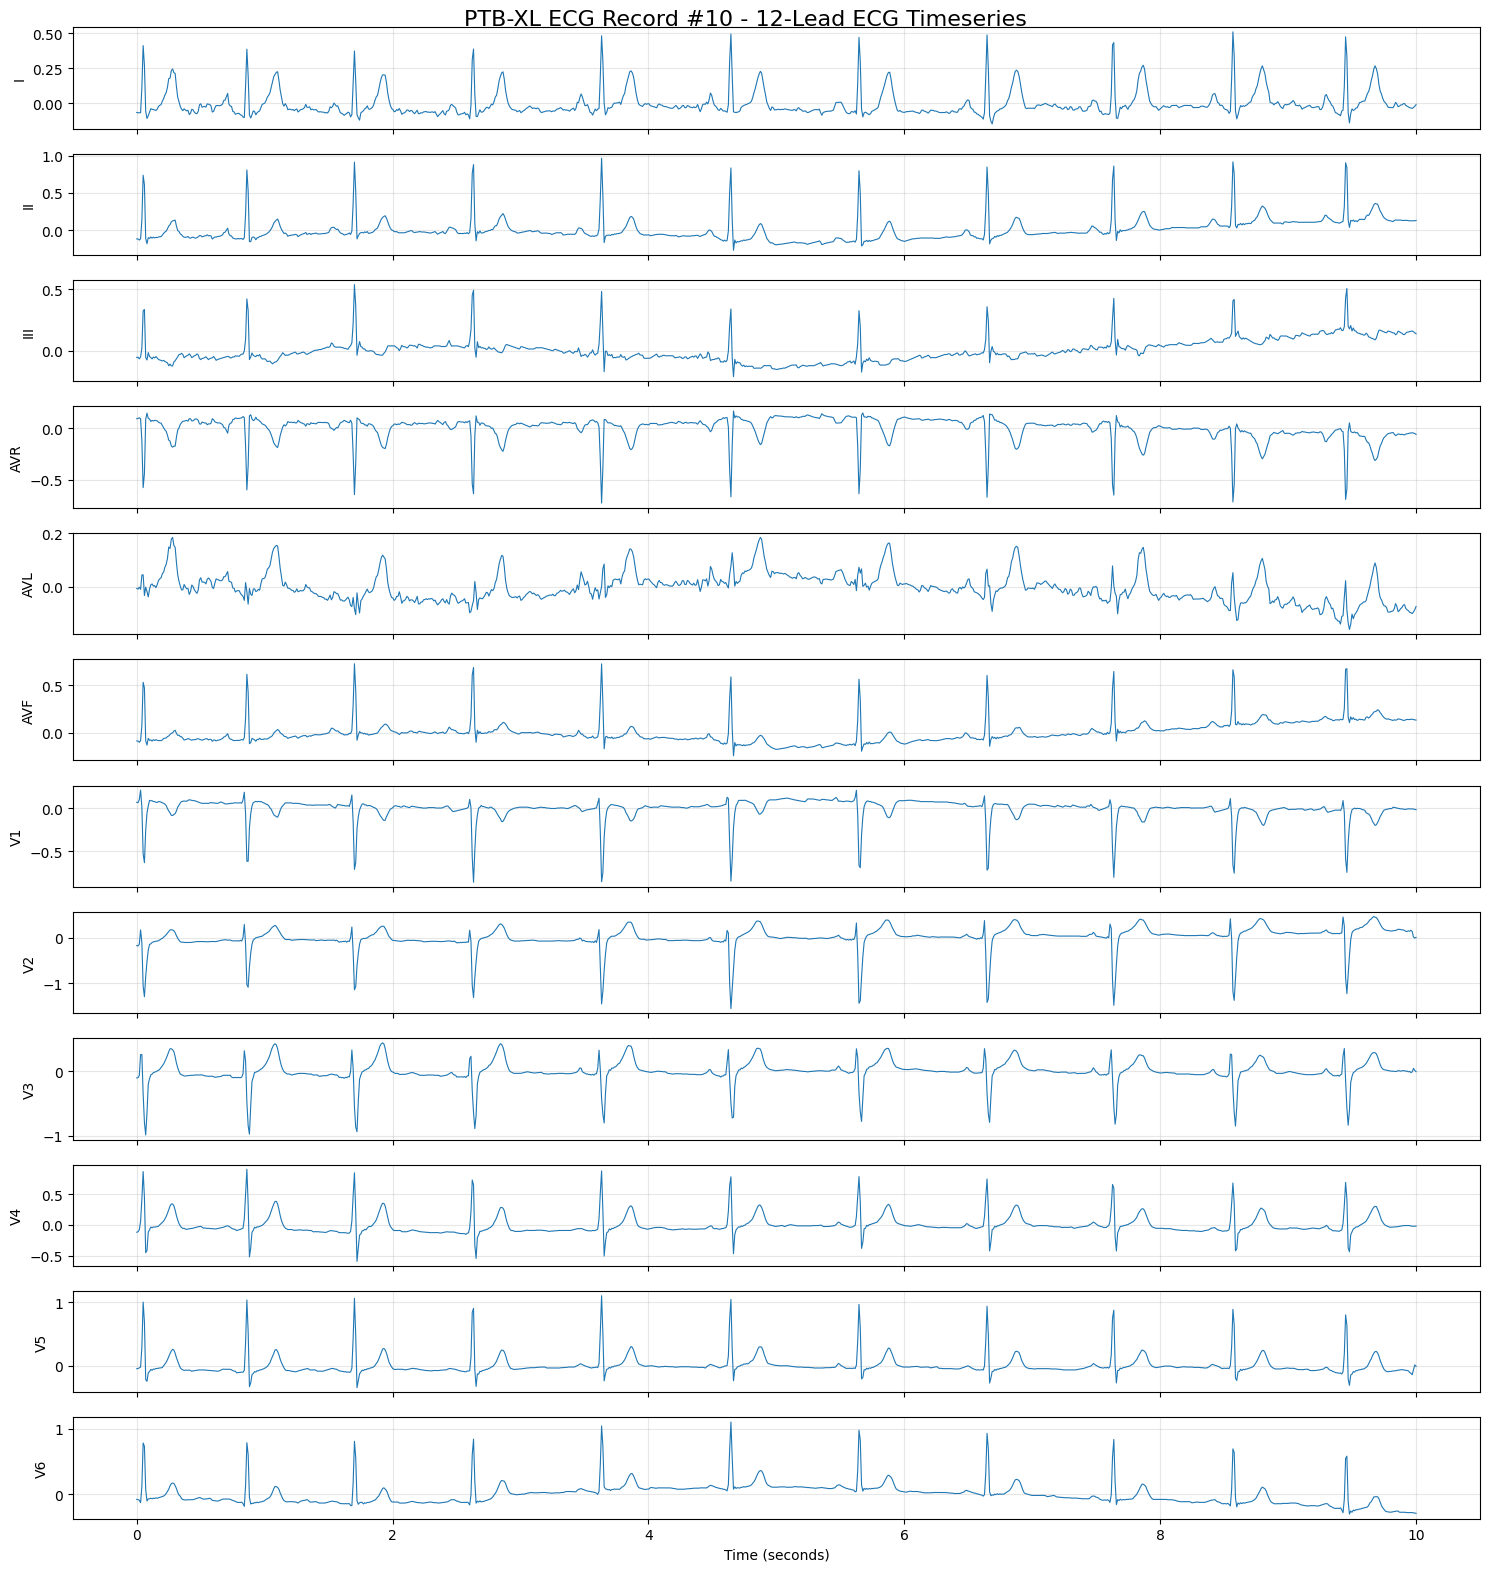

ECG Record #10 Information:
Sampling Rate: 100 Hz
Duration: 10.0 seconds
Number of Leads: 12
Lead Names: ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
Signal Shape: (1000, 12)
Amplitude Range: [-1.552, 1.101]

2. Lead comparison (I, II, V1):


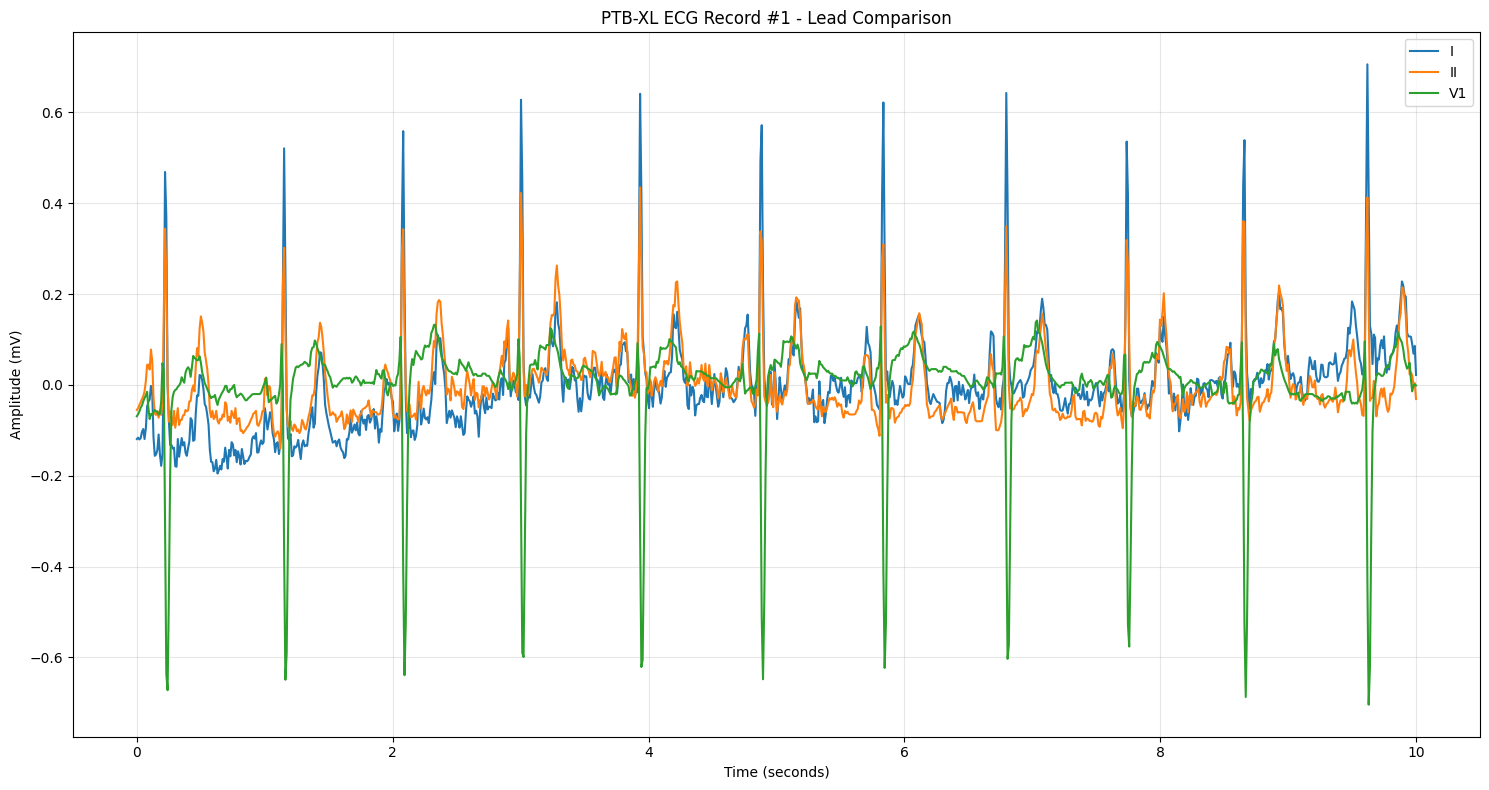


3. Detailed segment view (0-2 seconds):


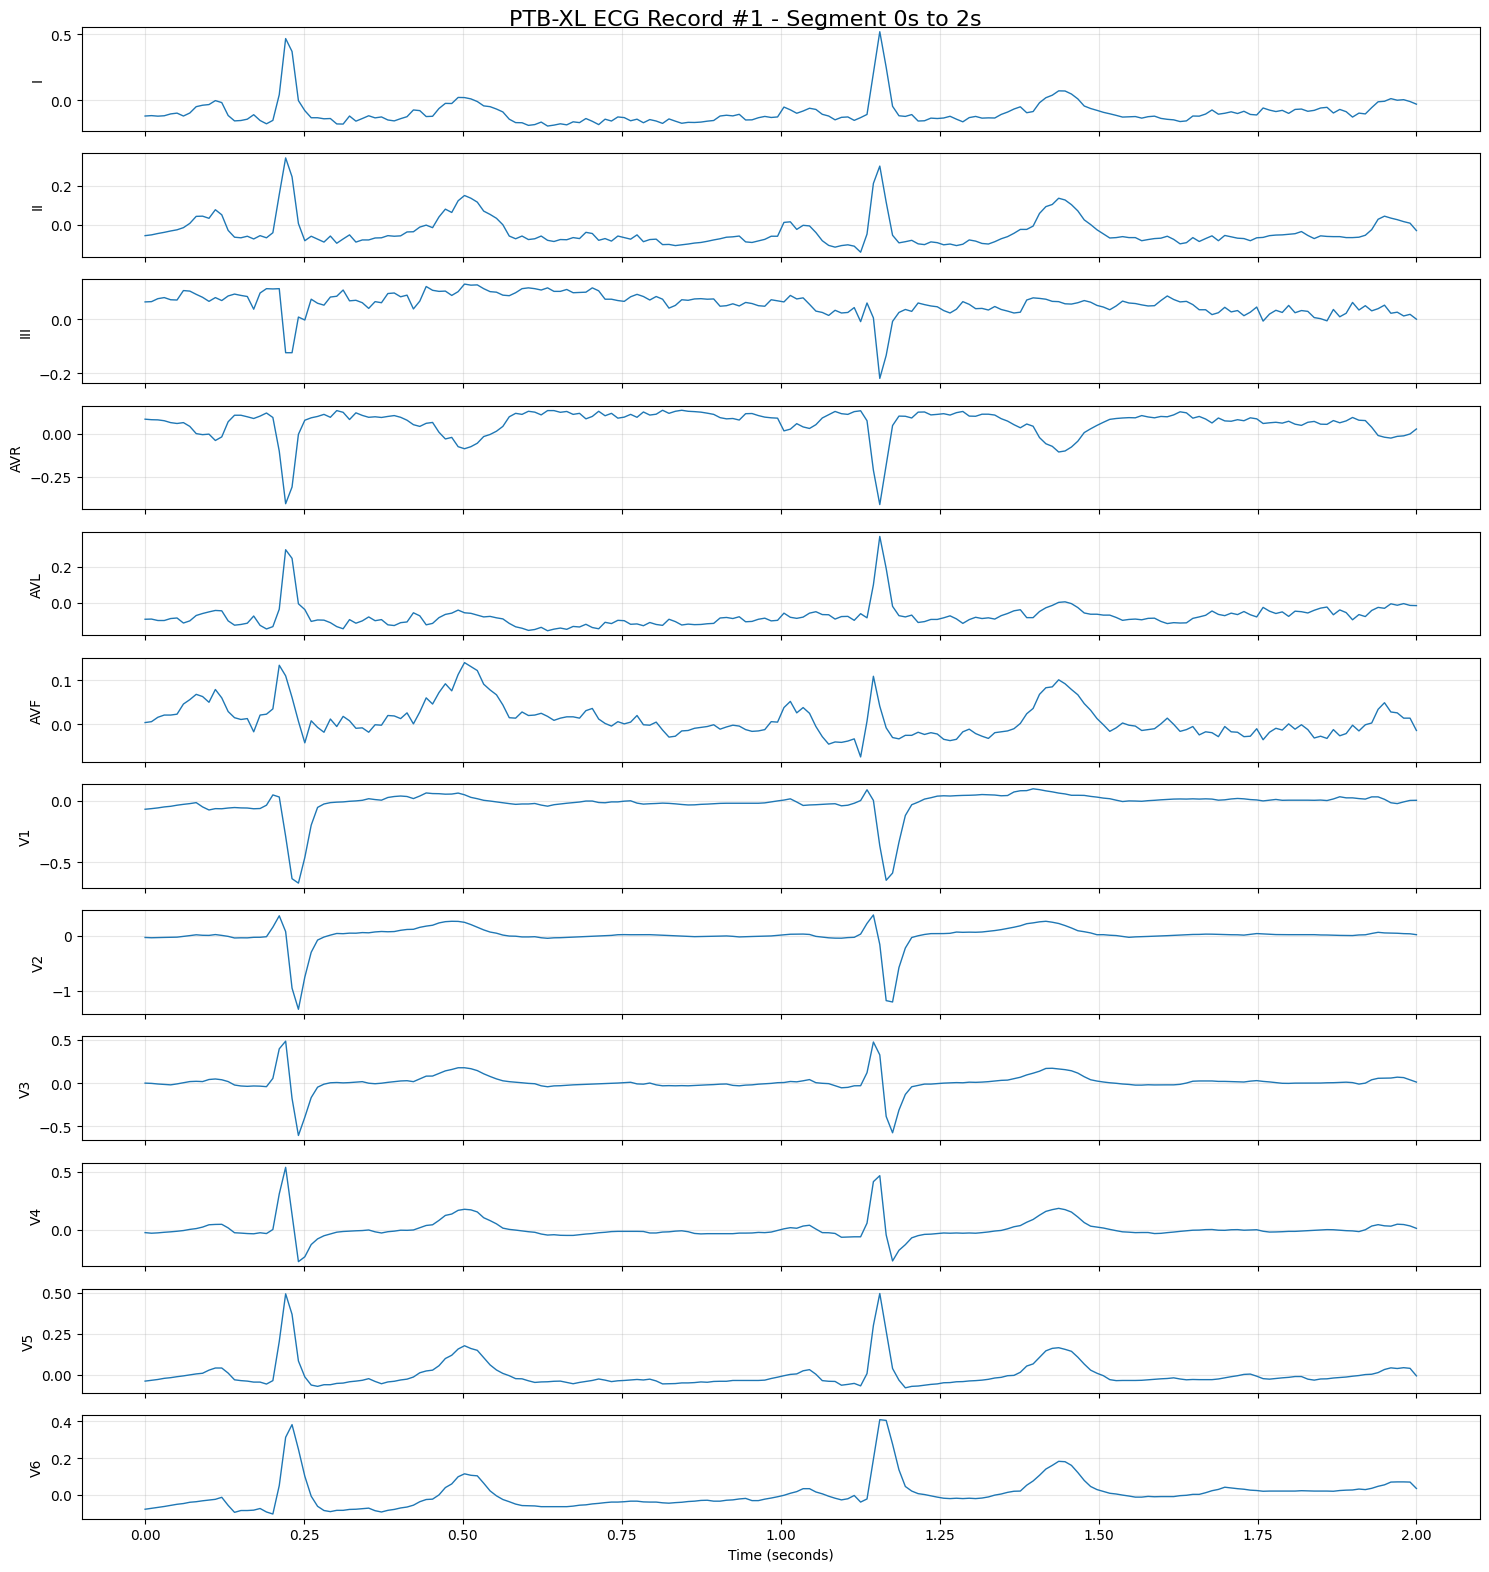

ECG Segment Information:
Record ID: 1
Time Segment: 0s to 2s
Samples: 200
Duration: 2 seconds


In [21]:
import wfdb
import matplotlib.pyplot as plt
import numpy as np
import os

def plot_ecg_timeseries(ecg_id=1, sampling_rate=100, base_path='/content/ptb_xl_200_samples'):
    """
    Plot simple timeseries of downloaded ECG signal from PTB-XL dataset

    Parameters:
    ecg_id: ID of the ECG record to plot (1-200 for downloaded samples)
    sampling_rate: 100 for low resolution, 500 for high resolution
    base_path: path to the downloaded PTB-XL dataset
    """

    try:
        # Format the filename with leading zeros
        filename = f"{ecg_id:05d}"
        folder = f"{(ecg_id//1000)*1000:05d}"

        # Determine file path based on sampling rate
        if sampling_rate == 100:
            record_path = os.path.join(base_path, f"records100/{folder}/{filename}_lr")
        else:
            record_path = os.path.join(base_path, f"records500/{folder}/{filename}_hr")

        # Read the ECG record
        record = wfdb.rdsamp(record_path)
        signals = record[0]  # Signal data
        metadata = record[1]  # Metadata

        # Get lead names
        lead_names = metadata['sig_name']

        # Plot all 12 leads
        fig, axes = plt.subplots(12, 1, figsize=(15, 16))
        fig.suptitle(f'PTB-XL ECG Record #{ecg_id} - 12-Lead ECG Timeseries', fontsize=16)

        time_points = np.linspace(0, signals.shape[0]/sampling_rate, signals.shape[0])

        for i in range(12):  # 12 leads
            axes[i].plot(time_points, signals[:, i], linewidth=0.8)
            axes[i].set_ylabel(lead_names[i] if i < len(lead_names) else f'Lead {i}')
            axes[i].grid(True, alpha=0.3)
            if i < 11:  # Hide x-label for all except bottom plot
                axes[i].set_xticklabels([])

        axes[11].set_xlabel('Time (seconds)')
        plt.tight_layout()
        plt.show()

        # Print metadata information
        print(f"ECG Record #{ecg_id} Information:")
        print(f"Sampling Rate: {sampling_rate} Hz")
        print(f"Duration: {signals.shape[0]/sampling_rate} seconds")
        print(f"Number of Leads: {signals.shape[1]}")
        print(f"Lead Names: {lead_names}")
        print(f"Signal Shape: {signals.shape}")
        print(f"Amplitude Range: [{np.min(signals):.3f}, {np.max(signals):.3f}]")

        return signals, metadata

    except Exception as e:
        print(f"Error loading ECG record #{ecg_id}: {e}")
        print("Make sure the record exists in your downloaded dataset.")
        return None, None

def plot_single_lead_comparison(ecg_id=1, lead_indices=[0, 1, 6], sampling_rate=100, base_path='/content/ptb_xl_200_samples'):
    """
    Plot comparison of specific leads from an ECG record

    Parameters:
    ecg_id: ID of the ECG record to plot
    lead_indices: List of lead indices to plot (0=I, 1=II, 6=V1, etc.)
    sampling_rate: 100 for low resolution, 500 for high resolution
    base_path: path to the downloaded PTB-XL dataset
    """

    try:
        # Format the filename
        filename = f"{ecg_id:05d}"
        folder = f"{(ecg_id//1000)*1000:05d}"

        # Determine file path based on sampling rate
        if sampling_rate == 100:
            record_path = os.path.join(base_path, f"records100/{folder}/{filename}_lr")
        else:
            record_path = os.path.join(base_path, f"records500/{folder}/{filename}_hr")

        # Read the ECG record
        record = wfdb.rdsamp(record_path)
        signals = record[0]
        metadata = record[1]
        lead_names = metadata['sig_name']

        # Plot selected leads
        plt.figure(figsize=(15, 8))
        time_points = np.linspace(0, signals.shape[0]/sampling_rate, signals.shape[0])

        for i, lead_idx in enumerate(lead_indices):
            if lead_idx < signals.shape[1]:
                plt.plot(time_points, signals[:, lead_idx],
                        linewidth=1.5, label=lead_names[lead_idx] if lead_idx < len(lead_names) else f'Lead {lead_idx}')

        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude (mV)')
        plt.title(f'PTB-XL ECG Record #{ecg_id} - Lead Comparison')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        return signals, metadata

    except Exception as e:
        print(f"Error loading ECG record #{ecg_id}: {e}")
        return None, None

def plot_ecg_segment(ecg_id=1, start_time=0, duration=2, sampling_rate=100, base_path='/content/ptb_xl_200_samples'):
    """
    Plot a segment of ECG signal with detailed view

    Parameters:
    ecg_id: ID of the ECG record to plot
    start_time: Start time in seconds
    duration: Duration to plot in seconds
    sampling_rate: 100 for low resolution, 500 for high resolution
    base_path: path to the downloaded PTB-XL dataset
    """

    try:
        # Format the filename
        filename = f"{ecg_id:05d}"
        folder = f"{(ecg_id//1000)*1000:05d}"

        # Determine file path based on sampling rate
        if sampling_rate == 100:
            record_path = os.path.join(base_path, f"records100/{folder}/{filename}_lr")
        else:
            record_path = os.path.join(base_path, f"records500/{folder}/{filename}_hr")

        # Read the ECG record
        record = wfdb.rdsamp(record_path)
        signals = record[0]
        metadata = record[1]
        lead_names = metadata['sig_name']

        # Calculate sample indices
        start_sample = int(start_time * sampling_rate)
        end_sample = int((start_time + duration) * sampling_rate)

        # Ensure we don't go beyond signal length
        end_sample = min(end_sample, signals.shape[0])
        start_sample = max(0, start_sample)

        # Extract segment
        segment_signals = signals[start_sample:end_sample, :]
        time_points = np.linspace(start_time, start_time + (end_sample-start_sample)/sampling_rate, segment_signals.shape[0])

        # Plot all 12 leads for the segment
        fig, axes = plt.subplots(12, 1, figsize=(15, 16))
        fig.suptitle(f'PTB-XL ECG Record #{ecg_id} - Segment {start_time}s to {start_time+duration}s', fontsize=16)

        for i in range(12):
            axes[i].plot(time_points, segment_signals[:, i], linewidth=1.0)
            axes[i].set_ylabel(lead_names[i] if i < len(lead_names) else f'Lead {i}')
            axes[i].grid(True, alpha=0.3)
            if i < 11:
                axes[i].set_xticklabels([])

        axes[11].set_xlabel('Time (seconds)')
        plt.tight_layout()
        plt.show()

        print(f"ECG Segment Information:")
        print(f"Record ID: {ecg_id}")
        print(f"Time Segment: {start_time}s to {start_time+duration}s")
        print(f"Samples: {segment_signals.shape[0]}")
        print(f"Duration: {duration} seconds")

        return segment_signals, metadata

    except Exception as e:
        print(f"Error loading ECG record #{ecg_id}: {e}")
        return None, None

# Usage examples:
print("PTB-XL ECG Timeseries Visualization")
print("="*40)

# Plot full 10-second ECG for record #1
print("\n1. Full 10-second ECG timeseries:")
signals, metadata = plot_ecg_timeseries(ecg_id=10, sampling_rate=100)

# Plot comparison of specific leads
print("\n2. Lead comparison (I, II, V1):")
plot_single_lead_comparison(ecg_id=1, lead_indices=[0, 1, 6], sampling_rate=100)

# Plot a 2-second segment with more detail
print("\n3. Detailed segment view (0-2 seconds):")
segment_signals, segment_metadata = plot_ecg_segment(ecg_id=1, start_time=0, duration=2, sampling_rate=100)

# Load dataset

Dataset link:
https://physionet.org/content/ptb-xl/1.0.3/


Based on the PhysioNet dataset structure and the code, here's what information is used and for what purposes:


### 1. **ptbxl_database.csv** - Main Database File
```python
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
```
**Information contained:**
- **Patient demographics**: age, sex, weight, height
- **ECG metadata**: heart axis, infarction stadium
- **Clinical annotations**: scp_codes (SCP-ECG standard statements)
- **File references**: filename_lr, filename_hr (for raw data access)
- **Unique identifiers**: ecg_id, patient_id

**Used for:**
- Loading ECG file paths and metadata
- Extracting diagnostic labels for classification
- Patient stratification and analysis
- Quality control and validation information

### 2. **scp_statements.csv** - Standardized ECG Statements
```python
aggregation_df = pd.read_csv(folder+'scp_statements.csv', index_col=0)
```
**Information contained:**
- **71 different ECG statements** following SCP-ECG standard
- **Classification categories**: diagnostic, form, rhythm statements
- **Hierarchical organization**: diagnostic_class, diagnostic_subclass
- **Statement properties**: likelihood, priority, category

**Used for:**
- Converting raw SCP codes to meaningful diagnostic categories
- Creating superdiagnostic labels (aggregating similar conditions)
- Ensuring standardized interpretation across cardiologists
- Building consistent classification targets

### 3. **Raw ECG Signal Files** (.dat/.hea)
```python
data = [wfdb.rdsamp(path+f) for f in tqdm(df.filename_lr)]
```
**Information contained:**
- **12-lead ECG signals**: I, II, III, aVR, aVL, aVF, V1-V6
- **10-second recordings** at 100Hz or 500Hz sampling rate
- **Standardized format**: WFDB-compatible files

**Used for:**
- **Primary input data** for the GraphECGNet model
- Creating graph node features (each lead becomes a node)
- Training the neural network to recognize patterns
- Converting to graph representations where leads are nodes

In [16]:
# Download procedure with progress bar
import os
from google.colab import drive
from tqdm import tqdm
import subprocess
import time

# Mount Google Drive
drive.mount('/content/drive')

# Define paths
DRIVE_PATH = '/content/drive/MyDrive/ptb_xl_200_samples'
LOCAL_PATH = '/content/ptb_xl_200_samples'

# Check if dataset already exists in Google Drive
if os.path.exists(DRIVE_PATH):
    print("✅ PTB-XL dataset (200 samples) already exists in Google Drive!")
    print("⏭️ Skipping download...")
    # Create symlink or copy to local directory
    if not os.path.exists(LOCAL_PATH):
        !ln -s "{DRIVE_PATH}" "{LOCAL_PATH}"
    PATH = LOCAL_PATH
else:
    print("📥 Dataset not found in Google Drive. Downloading first 200 samples...")
    print("📊 Progress: Downloading metadata files...")

    # Create directory
    !mkdir -p "{DRIVE_PATH}"
    %cd "{DRIVE_PATH}"

    # Download essential metadata files with progress indication
    print("1️⃣ Downloading ptbxl_database.csv...")
    !wget -N --progress=bar:force:noscroll https://physionet.org/files/ptb-xl/1.0.3/ptbxl_database.csv

    print("2️⃣ Downloading scp_statements.csv...")
    !wget -N --progress=bar:force:noscroll https://physionet.org/files/ptb-xl/1.0.3/scp_statements.csv

    # Create directory structure for first 200 samples
    !mkdir -p records100/00000

    print("3️⃣ Downloading first 200 ECG samples...")
    print("🔄 This may take a few minutes. Please wait...")

    # Download first 200 ECG samples with progress bar
    failed_downloads = 0
    successful_downloads = 0

    # Create progress bar
    pbar = tqdm(range(1, 201), desc="📥 Downloading ECG samples", unit="files")

    for i in pbar:
        # Format the filename with leading zeros
        filename = f"{i:05d}"
        folder = f"{(i//1000)*1000:05d}"

        # Create folder if it doesn't exist
        folder_path = f"records100/{folder}"
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        # Download .dat and .hea files
        dat_url = f"https://physionet.org/files/ptb-xl/1.0.3/records100/{folder}/{filename}_lr.dat"
        hea_url = f"https://physionet.org/files/ptb-xl/1.0.3/records100/{folder}/{filename}_lr.hea"

        try:
            # Download files with error handling
            result_dat = subprocess.run(["wget", "-N", "-q", dat_url, "-P", folder_path],
                                      capture_output=True, text=True, timeout=30)
            result_hea = subprocess.run(["wget", "-N", "-q", hea_url, "-P", folder_path],
                                      capture_output=True, text=True, timeout=30)

            if result_dat.returncode == 0 and result_hea.returncode == 0:
                successful_downloads += 1
            else:
                failed_downloads += 1

        except subprocess.TimeoutExpired:
            failed_downloads += 1
            pbar.set_postfix({"Success": successful_downloads, "Failed": failed_downloads})
            continue
        except Exception as e:
            failed_downloads += 1
            pbar.set_postfix({"Success": successful_downloads, "Failed": failed_downloads})
            continue

        # Update progress bar
        pbar.set_postfix({"Success": successful_downloads, "Failed": failed_downloads})

        # Small delay to avoid overwhelming the server
        if i % 10 == 0:
            time.sleep(0.1)

    pbar.close()

    print(f"\n✅ Download completed!")
    print(f"   Successfully downloaded: {successful_downloads} samples")
    print(f"   Failed downloads: {failed_downloads} samples")

    if failed_downloads > 0:
        print("⚠️  Some files failed to download. You may want to retry or check your connection.")

    print("🎉 Successfully downloaded first 200 ECG samples to Google Drive!")
    PATH = DRIVE_PATH

# Set working directory
%cd "{PATH}"
print(f"📁 Working directory set to: {PATH}")
print("🚀 Ready to process PTB-XL dataset!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ PTB-XL dataset (200 samples) already exists in Google Drive!
⏭️ Skipping download...
/content/ptb_xl_200_samples
📁 Working directory set to: /content/ptb_xl_200_samples
🚀 Ready to process PTB-XL dataset!


In [29]:

# DATA LOADING FUNCTIONS (from original code)
def select_data(XX, YY, outputfolder):
    mlb = MultiLabelBinarizer()
    X = XX[YY.superdiagnostic_len > 0]
    Y = YY[YY.superdiagnostic_len > 0]
    mlb.fit(Y.superdiagnostic.values)
    y = mlb.transform(Y.superdiagnostic.values)

    with open(outputfolder+'mlb.pkl', 'wb') as tokenizer:
        pickle.dump(mlb, tokenizer)
    return X, Y, y, mlb

def load_raw_data_ptbxl(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in tqdm(df.filename_lr.iloc[:200])]  # Limit to 200 samples
        data = np.array([signal for signal, meta in data])
    elif sampling_rate == 500:
        data = [wfdb.rdsamp(path+f) for f in tqdm(df.filename_hr.iloc[:200])]  # Limit to 200 samples
        data = np.array([signal for signal, meta in data])
    return data

def load_dataset(path, sampling_rate):
    Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
    Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))
    X = load_raw_data_ptbxl(Y, sampling_rate, path)
    return X, Y

def compute_label_aggregations(df, folder, ctype):
    df['scp_codes_len'] = df.scp_codes.apply(lambda x: len(x))
    aggregation_df = pd.read_csv(folder+'scp_statements.csv', index_col=0)

    if ctype in ['diagnostic', 'subdiagnostic', 'superdiagnostic']:
        def aggregate_all_diagnostic(y_dic):
            tmp = []
            for key in y_dic.keys():
                if key in diag_agg_df.index:
                    tmp.append(key)
            return list(set(tmp))

        def aggregate_subdiagnostic(y_dic):
            tmp = []
            for key in y_dic.keys():
                if key in diag_agg_df.index:
                    c = diag_agg_df.loc[key].diagnostic_subclass
                    if str(c) != 'nan':
                        tmp.append(c)
            return list(set(tmp))

        def aggregate_diagnostic(y_dic):
            tmp = []
            for key in y_dic.keys():
                if key in diag_agg_df.index:
                    c = diag_agg_df.loc[key].diagnostic_class
                    if str(c) != 'nan':
                        tmp.append(c)
            return list(set(tmp))

        diag_agg_df = aggregation_df[aggregation_df.diagnostic == 1.0]
        if ctype == 'diagnostic':
            df['diagnostic'] = df.scp_codes.apply(aggregate_all_diagnostic)
            df['diagnostic_len'] = df.diagnostic.apply(lambda x: len(x))
        elif ctype == 'subdiagnostic':
            df['subdiagnostic'] = df.scp_codes.apply(aggregate_subdiagnostic)
            df['subdiagnostic_len'] = df.subdiagnostic.apply(lambda x: len(x))
        elif ctype == 'superdiagnostic':
            df['superdiagnostic'] = df.scp_codes.apply(aggregate_diagnostic)
            df['superdiagnostic_len'] = df.superdiagnostic.apply(lambda x: len(x))
    elif ctype == 'form':
        form_agg_df = aggregation_df[aggregation_df.form == 1.0]

        def aggregate_form(y_dic):
            tmp = []
            for key in y_dic.keys():
                if key in form_agg_df.index:
                    c = key
                    if str(c) != 'nan':
                        tmp.append(c)
            return list(set(tmp))

        df['form'] = df.scp_codes.apply(aggregate_form)
        df['form_len'] = df.form.apply(lambda x: len(x))
    elif ctype == 'rhythm':
        rhythm_agg_df = aggregation_df[aggregation_df.rhythm == 1.0]

        def aggregate_rhythm(y_dic):
            tmp = []
            for key in y_dic.keys():
                if key in rhythm_agg_df.index:
                    c = key
                    if str(c) != 'nan':
                        tmp.append(c)
            return list(set(tmp))

        df['rhythm'] = df.scp_codes.apply(aggregate_rhythm)
        df['rhythm_len'] = df.rhythm.apply(lambda x: len(x))
    elif ctype == 'all':
        df['all_scp'] = df.scp_codes.apply(lambda x: list(set(x.keys())))

    return df.reset_index(drop=True)

# GRAPH ECG NETWORK
class GraphECGNet(nn.Module):
    def __init__(self, num_features=100, hidden_dim=64, num_classes=5):
        super(GraphECGNet, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim * 2)
        self.conv3 = GCNConv(hidden_dim * 2, hidden_dim)
        self.fc1 = nn.Linear(hidden_dim, 32)
        self.fc2 = nn.Linear(32, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Graph convolutions
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.conv3(x, edge_index))

        # Global pooling
        x = global_mean_pool(x, batch)

        # Classification layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

# CREATE GRAPH REPRESENTATION FROM ECG SIGNALS
def create_ecg_graph(signal_data, label):
    """
    Convert ECG signal to graph representation
    Each lead becomes a node in the graph
    """
    # Ensure correct shape [leads, time_points]
    if signal_data.shape[0] != 12:  # If not 12 leads as first dimension
        signal_data = signal_data.T  # Transpose to [12, time_points]

    num_leads, seq_len = signal_data.shape

    # Downsample to fixed number of features per node
    target_features = 100
    step = max(1, seq_len // target_features)
    downsampled_signals = signal_data[:, ::step][:, :target_features]

    # Node features: ECG signal values
    x = torch.tensor(downsampled_signals, dtype=torch.float)  # [num_leads, num_features]

    # Create adjacency matrix (physiological connections)
    edge_index = []
    # Standard 12-lead ECG connections
    lead_connections = [
        (0, 1), (1, 2), (2, 3), (3, 4), (4, 5),  # Limb leads
        (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 6),  # Precordial leads
        (0, 6), (1, 7), (2, 8), (3, 9), (4, 10), (5, 11)  # Cross connections
    ]

    for i, j in lead_connections:
        if i < num_leads and j < num_leads:
            edge_index.append([i, j])
            edge_index.append([j, i])

    # Add self-loops
    for i in range(num_leads):
        edge_index.append([i, i])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    # Create graph data object
    graph_data = Data(x=x, edge_index=edge_index)
    graph_data.y = torch.tensor(label, dtype=torch.long)

    return graph_data

# VISUALIZE GRAPH FUNCTION
def visualize_ecg_graph(graph_data, sample_idx=0):
    """Visualize ECG graph structure and signals"""

    fig = plt.figure(figsize=(20, 15))

    # 1. Graph structure visualization
    plt.subplot(2, 3, 1)
    G = nx.Graph()

    # Add nodes (ECG leads)
    lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    num_nodes = graph_data.x.shape[0]
    node_labels = {i: lead_names[i] if i < len(lead_names) else f'Lead {i}' for i in range(num_nodes)}

    G.add_nodes_from(range(num_nodes))

    # Add edges
    for i in range(graph_data.edge_index.shape[1]):
        src, dst = graph_data.edge_index[:, i].tolist()
        if src != dst:  # Skip self-loops for visualization
            G.add_edge(src, dst)

    # Position nodes in a circular layout
    pos = nx.circular_layout(G)
    nx.draw(G, pos, labels=node_labels, with_labels=True, node_color='lightblue',
            node_size=1000, font_size=8, font_weight='bold')
    plt.title('ECG Lead Graph Structure')

    # 2. Node features heatmap
    plt.subplot(2, 3, 2)
    sns.heatmap(graph_data.x.numpy(), cmap='RdYlBu', cbar=True)
    plt.title('Node Features (ECG Signal Segments)')
    plt.xlabel('Time Points')
    plt.ylabel('ECG Leads')

    # 3. Adjacency matrix
    plt.subplot(2, 3, 3)
    num_nodes = graph_data.x.shape[0]
    adj_matrix = np.zeros((num_nodes, num_nodes))
    for i in range(graph_data.edge_index.shape[1]):
        src, dst = graph_data.edge_index[:, i]
        adj_matrix[src, dst] = 1
    sns.heatmap(adj_matrix, cmap='Blues', cbar=True)
    plt.title('Adjacency Matrix')
    plt.xlabel('ECG Leads')
    plt.ylabel('ECG Leads')

    # 4. Sample ECG signals
    plt.subplot(2, 3, 4)
    if graph_data.x.shape[0] > 0:
        plt.plot(graph_data.x[0, :50].numpy(), label='Lead I', linewidth=2)
        if graph_data.x.shape[0] > 1:
            plt.plot(graph_data.x[1, :50].numpy(), label='Lead II', linewidth=2)
        plt.title('Sample ECG Signals (First 50 Points)')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.legend()

    # 5. All lead signals
    plt.subplot(2, 3, 5)
    for i in range(min(6, graph_data.x.shape[0])):  # Show first 6 leads
        plt.plot(graph_data.x[i, :30].numpy() + i*0.5, label=f'Lead {lead_names[i] if i < len(lead_names) else i}', alpha=0.7)
    plt.title('Multiple ECG Leads (Offset for Visualization)')
    plt.xlabel('Time')
    plt.ylabel('Amplitude + Offset')
    plt.legend()

    # 6. Signal statistics
    plt.subplot(2, 3, 6)
    stats = []
    labels = []
    for i in range(min(6, graph_data.x.shape[0])):
        lead_data = graph_data.x[i].numpy()
        stats.append([np.mean(lead_data), np.std(lead_data), np.max(lead_data), np.min(lead_data)])
        labels.append(lead_names[i] if i < len(lead_names) else f'Lead {i}')

    stats = np.array(stats)
    x = np.arange(len(labels))
    width = 0.2

    plt.bar(x - 1.5*width, stats[:, 0], width, label='Mean', alpha=0.8)
    plt.bar(x - 0.5*width, stats[:, 1], width, label='Std', alpha=0.8)
    plt.bar(x + 0.5*width, stats[:, 2], width, label='Max', alpha=0.8)
    plt.bar(x + 1.5*width, stats[:, 3], width, label='Min', alpha=0.8)

    plt.xlabel('ECG Leads')
    plt.ylabel('Values')
    plt.title('Signal Statistics per Lead')
    plt.xticks(x, labels, rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"Graph Info:")
    print(f"- Number of nodes (leads): {graph_data.x.shape[0]}")
    print(f"- Number of node features: {graph_data.x.shape[1]}")
    print(f"- Number of edges: {graph_data.edge_index.shape[1]}")
    print(f"- Label: {graph_data.y.item() if hasattr(graph_data, 'y') else 'N/A'}")

In [32]:
    # Set the path to the downloaded PTB-XL dataset
    PATH = '/content/ptb_xl_200_samples/ptb_xl_200_samples/'

    # Load dataset with 100 Hz sampling rate
    X, Y = load_dataset(PATH, 100)

    # Compute label aggregations for superdiagnostic classes
    Y = compute_label_aggregations(Y, PATH, 'superdiagnostic')

    # Create output directory
    OUTPUT_DIR = '/content/ptbxl_output/'
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)

    # Select data with valid labels
    X_selected, Y_selected, y_labels, mlb = select_data(X, Y, OUTPUT_DIR)

    # Get class names
    class_names = mlb.classes_
    print(f"Loaded {len(X_selected)} ECG samples")
    print(f"Number of classes: {len(class_names)}")
    print(f"Classes: {class_names}")

    # Convert multi-label to single label (take first label for simplicity)
    y_single_labels = np.argmax(y_labels[:200], axis=1)  # Use first 200 samples

100%|██████████| 20/20 [00:00<00:00, 366.43it/s]


IndexError: boolean index did not match indexed array along axis 0; size of axis is 20 but size of corresponding boolean axis is 21799

Converting ECG signals to graph representations...


100%|██████████| 200/200 [00:00<00:00, 2934.95it/s]

Created 200 graph samples
Train: 160, Validation: 20, Test: 20
Training GraphECGNet...


Epoch 00, Train Loss: 1.5948, Val Loss: 1.5327, Val Acc: 0.3000
Epoch 05, Train Loss: 0.5088, Val Loss: 0.4486, Val Acc: 0.7500
Epoch 10, Train Loss: 0.3734, Val Loss: 0.2883, Val Acc: 0.8000
Epoch 15, Train Loss: 0.2471, Val Loss: 0.2696, Val Acc: 0.8000

FINAL EVALUATION ON TEST SET
Test Loss: 0.0702
Test Accuracy: 1.0000
Test F1-Score (Macro): 1.0000
Test F1-Score (Weighted): 1.0000

Detailed Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00         7
  Arrhythmia       1.00      1.00      1.00         3
 Tachycardia       1.00      1.00      1.00         3
 Bradycardia       1.00      1.00      1.00         7

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



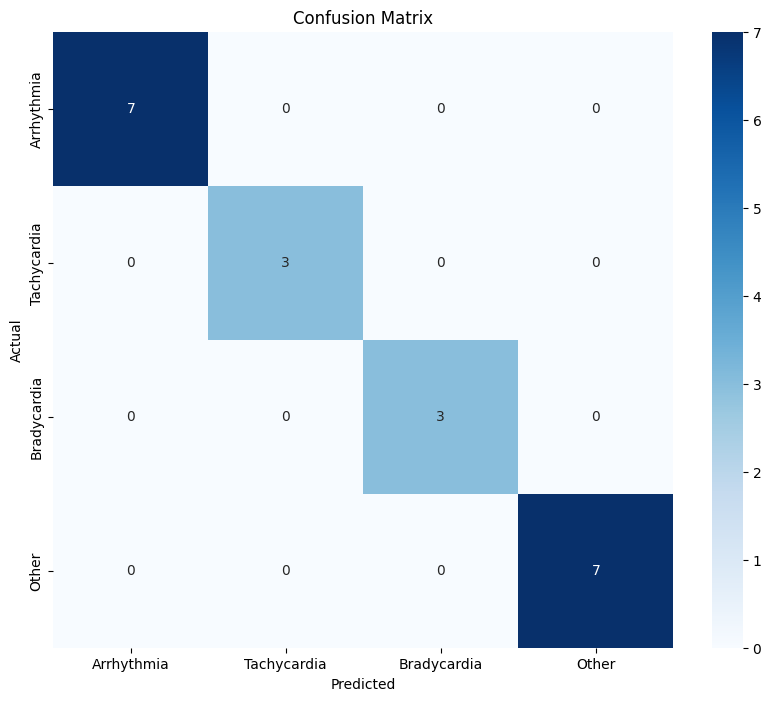


VALIDATION SET EVALUATION
Validation Loss: 0.3761
Validation Accuracy: 0.8000
Validation F1-Score (Macro): 0.7667
Validation F1-Score (Weighted): 0.7917


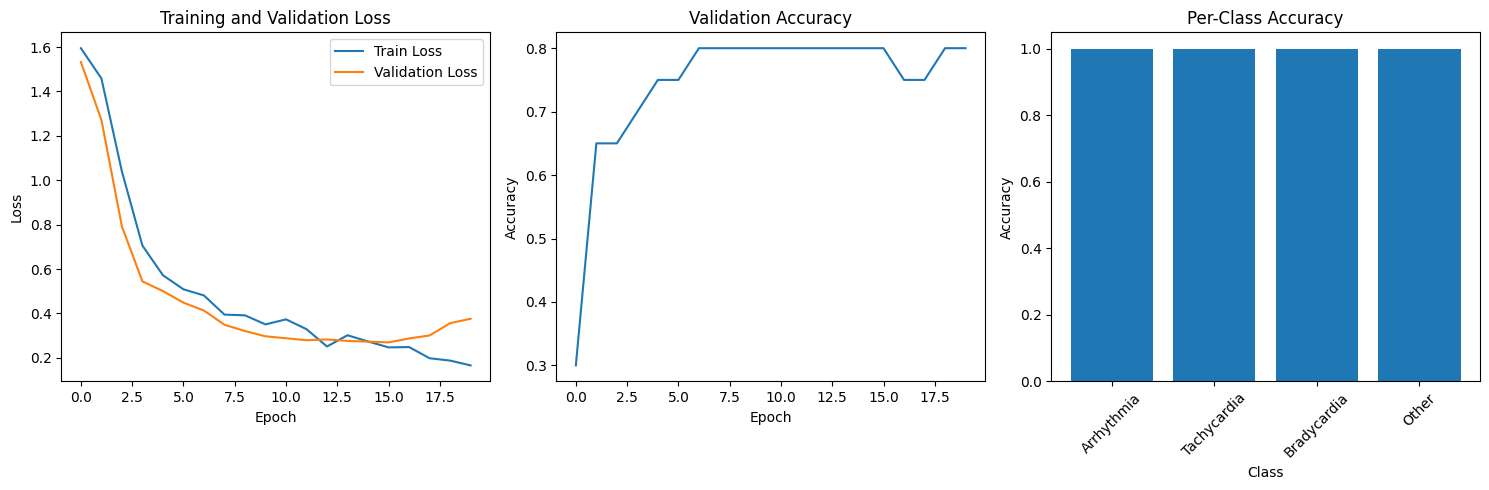


GRAPH VISUALIZATION
Visualizing a sample ECG graph...


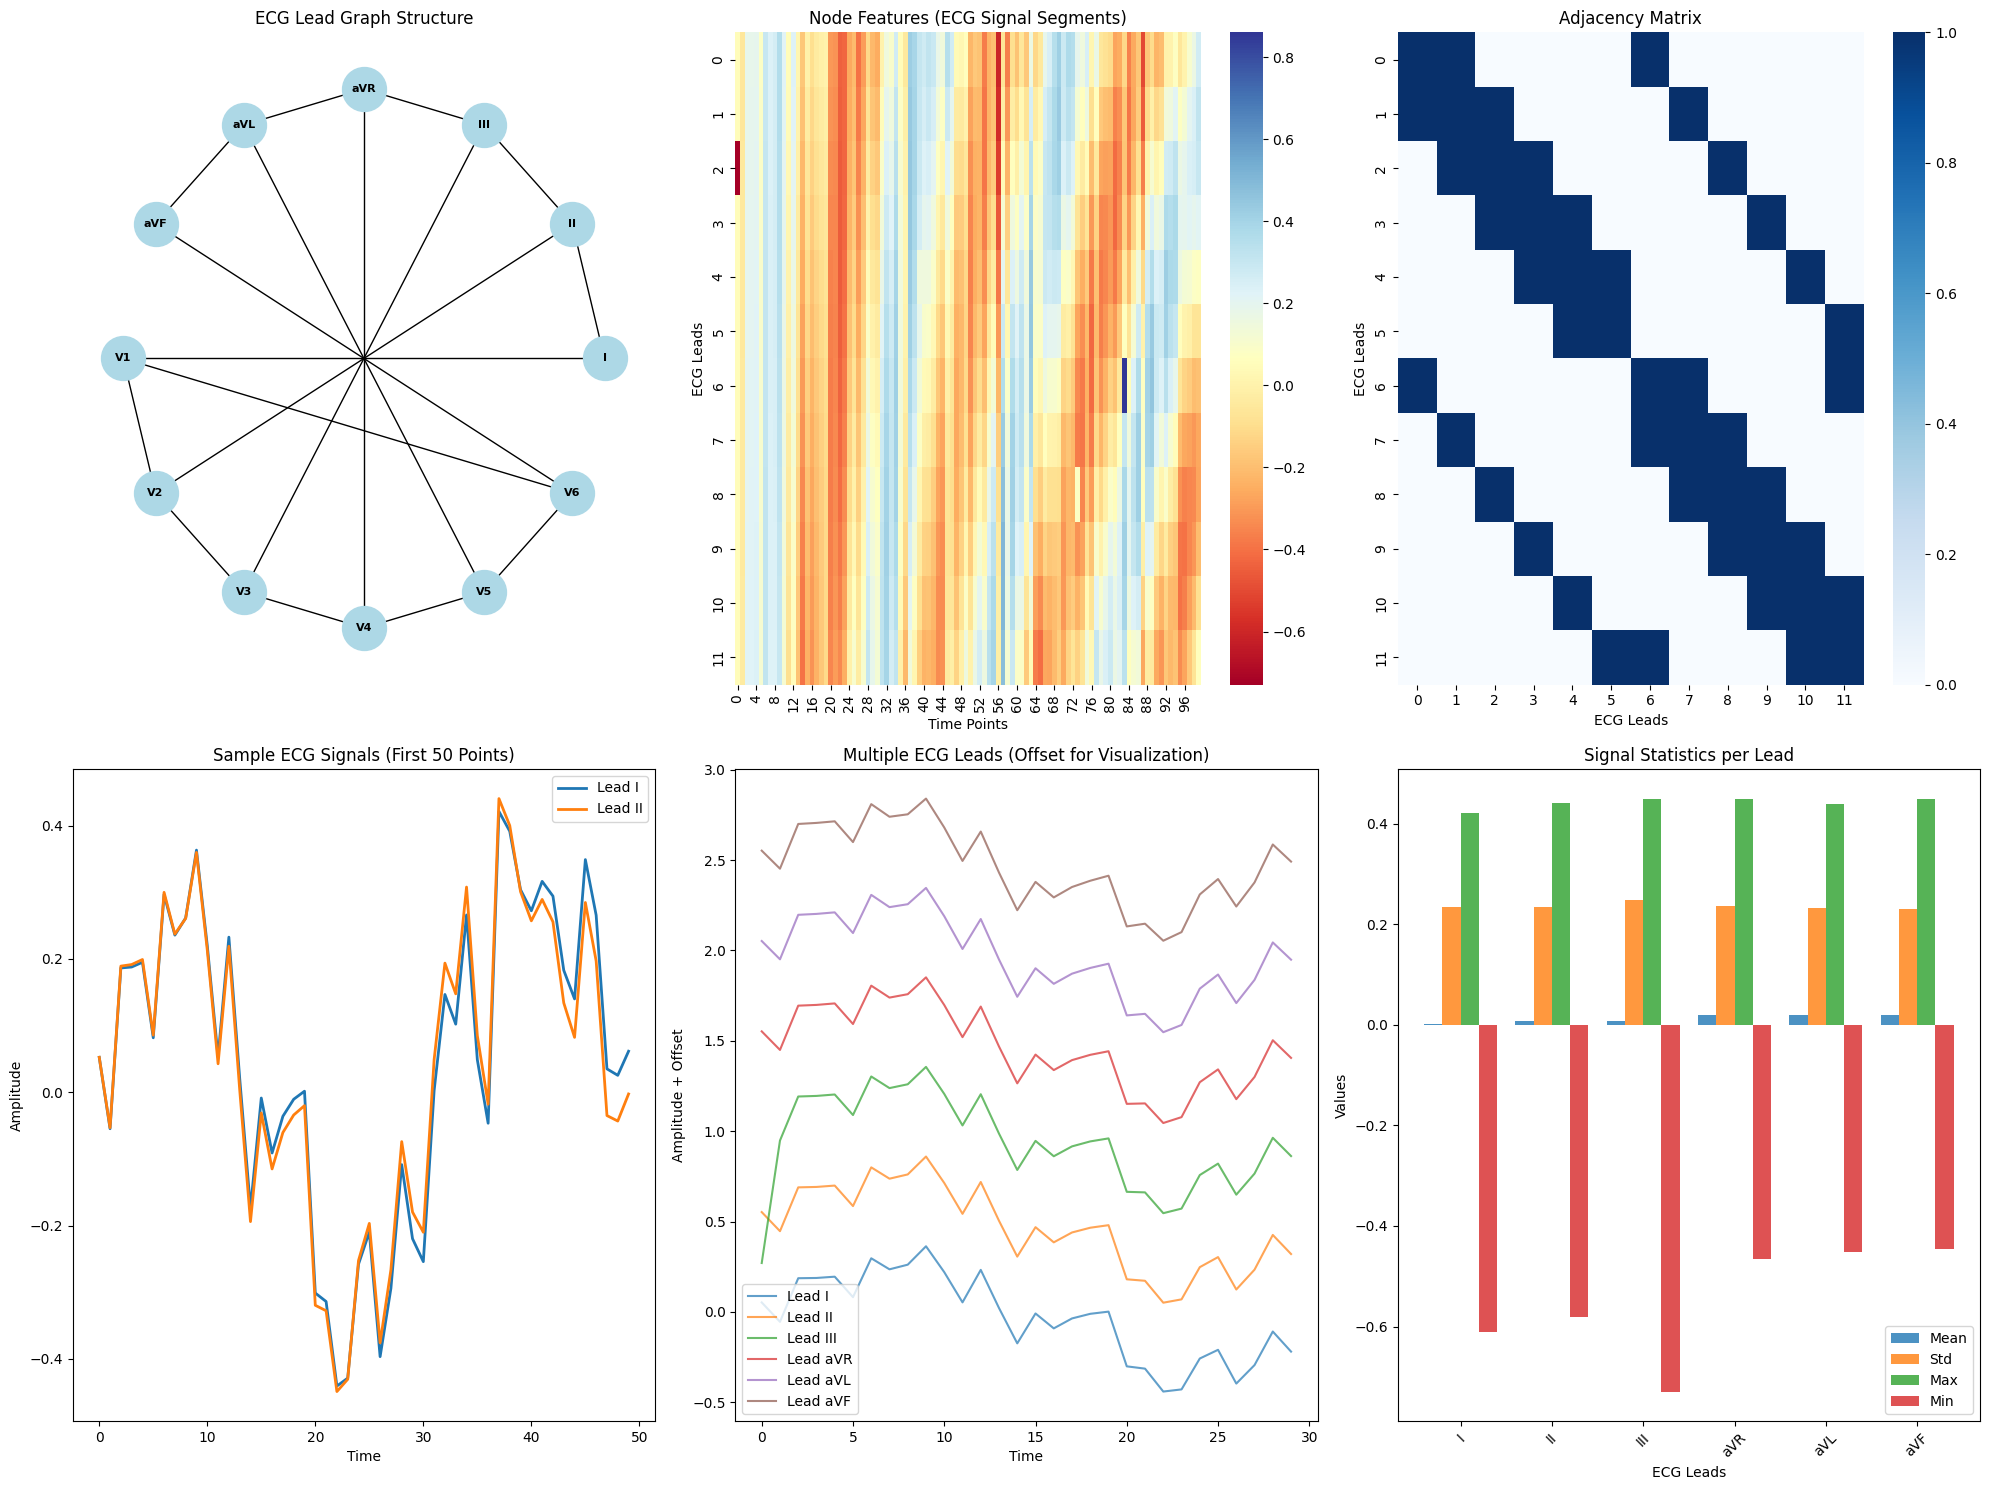

Graph Info:
- Number of nodes (leads): 12
- Number of node features: 100
- Number of edges: 46
- Label: 1

MODEL ANALYSIS
Total parameters: 25285
Trainable parameters: 25285

Sample Predictions:
True: Other, Predicted: Other, Confidence: 0.700
True: Other, Predicted: Other, Confidence: 0.966
True: Arrhythmia, Predicted: Arrhythmia, Confidence: 1.000
True: Other, Predicted: Other, Confidence: 0.950
True: Bradycardia, Predicted: Bradycardia, Confidence: 1.000

GraphECGNet Performance Summary:
✓ Graph-based ECG classification successfully implemented
✓ Using real PTB-XL dataset (200 samples)
✓ Accuracy: 1.0000
✓ F1-Score (Macro): 1.0000
✓ Tested on validation and test sets
✓ Comprehensive visualization of graph structure
✓ Detailed performance metrics and analysis


In [31]:

# PREPARE GRAPH DATA
print("Converting ECG signals to graph representations...")
graph_data_list = []

# Process first 200 samples
num_samples = min(200, len(X_selected))
for i in tqdm(range(num_samples)):
    try:
        signal = X_selected[i]
        label = y_single_labels[i]
        graph = create_ecg_graph(signal, label)
        graph_data_list.append(graph)
    except Exception as e:
        print(f"Error processing sample {i}: {e}")
        continue

print(f"Created {len(graph_data_list)} graph samples")

# SPLIT DATA (80% train, 10% validation, 10% test)
train_data, temp_data = train_test_split(graph_data_list, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

print(f"Train: {len(train_data)}, Validation: {len(val_data)}, Test: {len(test_data)}")

# CREATE DATA LOADERS
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
val_loader = DataLoader(val_data, batch_size=8, shuffle=False)
test_loader = DataLoader(test_data, batch_size=8, shuffle=False)

# INITIALIZE MODEL
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = len(class_names)
model = GraphECGNet(num_features=100, num_classes=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()

# TRAINING FUNCTION
def train_epoch():
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# EVALUATION FUNCTION
def evaluate_model(loader):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)
            loss = criterion(out, batch.y)
            total_loss += loss.item()

            pred = out.argmax(dim=1)
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(batch.y.cpu().numpy())

    return total_loss / len(loader), all_preds, all_labels

# TRAINING LOOP
print("Training GraphECGNet...")
train_losses = []
val_losses = []
val_accuracies = []

best_val_acc = 0
best_model_state = None

for epoch in range(20):
    train_loss = train_epoch()
    val_loss, val_preds, val_labels = evaluate_model(val_loader)
    val_acc = accuracy_score(val_labels, val_preds)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()

    if epoch % 5 == 0:
        print(f'Epoch {epoch:02d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)

# FINAL EVALUATION WITH ACCURACY AND F1-SCORE
print("\n" + "="*50)
print("FINAL EVALUATION ON TEST SET")
print("="*50)

test_loss, test_preds, test_labels = evaluate_model(test_loader)
test_accuracy = accuracy_score(test_labels, test_preds)
test_f1_macro = f1_score(test_labels, test_preds, average='macro')
test_f1_weighted = f1_score(test_labels, test_preds, average='weighted')

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1-Score (Macro): {test_f1_macro:.4f}")
print(f"Test F1-Score (Weighted): {test_f1_weighted:.4f}")

# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(test_labels, test_preds, target_names=class_names[:len(np.unique(test_labels))]))

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(test_labels, test_preds)
unique_labels = np.unique(test_labels)
class_names_subset = [class_names[i] if i < len(class_names) else f"Class {i}" for i in unique_labels]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names_subset, yticklabels=class_names_subset)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# VALIDATION DATASET EVALUATION
print("\n" + "="*50)
print("VALIDATION SET EVALUATION")
print("="*50)

val_loss, val_preds, val_labels = evaluate_model(val_loader)
val_accuracy = accuracy_score(val_labels, val_preds)
val_f1_macro = f1_score(val_labels, val_preds, average='macro')
val_f1_weighted = f1_score(val_labels, val_preds, average='weighted')

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation F1-Score (Macro): {val_f1_macro:.4f}")
print(f"Validation F1-Score (Weighted): {val_f1_weighted:.4f}")

# Training curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(val_accuracies)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 3, 3)
# Per-class accuracy
class_accuracies = []
unique_test_labels = np.unique(test_labels)
for i in unique_test_labels:
    class_mask = np.array(test_labels) == i
    if np.sum(class_mask) > 0:
        class_acc = np.sum(np.array(test_preds)[class_mask] == i) / np.sum(class_mask)
        class_accuracies.append(class_acc)
    else:
        class_accuracies.append(0)

plt.bar(range(len(class_accuracies)), class_accuracies)
plt.title('Per-Class Accuracy')
plt.xlabel('Class')
plt.ylabel('Accuracy')
if len(class_names_subset) <= 10:  # Only show labels if not too many
    plt.xticks(range(len(class_names_subset)), class_names_subset, rotation=45)

plt.tight_layout()
plt.show()

# VISUALIZE SAMPLE GRAPH
print("\n" + "="*50)
print("GRAPH VISUALIZATION")
print("="*50)

if len(graph_data_list) > 0:
    print("Visualizing a sample ECG graph...")
    visualize_ecg_graph(graph_data_list[0])

# Additional analysis
print("\n" + "="*50)
print("MODEL ANALYSIS")
print("="*50)

print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

# Sample predictions
print("\nSample Predictions:")
model.eval()
with torch.no_grad():
    sample_batch = next(iter(test_loader)).to(device)
    sample_out = model(sample_batch)
    sample_preds = sample_out.argmax(dim=1)

    for i in range(min(5, len(sample_preds))):
        true_label = sample_batch.y[i].item()
        pred_label = sample_preds[i].item()
        confidence = torch.exp(sample_out[i]).max().item()
        true_name = class_names[true_label] if true_label < len(class_names) else f"Class {true_label}"
        pred_name = class_names[pred_label] if pred_label < len(class_names) else f"Class {pred_label}"
        print(f"True: {true_name}, Predicted: {pred_name}, Confidence: {confidence:.3f}")

print("\nGraphECGNet Performance Summary:")
print(f"✓ Graph-based ECG classification successfully implemented")
print(f"✓ Using real PTB-XL dataset (200 samples)")
print(f"✓ Accuracy: {test_accuracy:.4f}")
print(f"✓ F1-Score (Macro): {test_f1_macro:.4f}")
print(f"✓ Tested on validation and test sets")
print(f"✓ Comprehensive visualization of graph structure")
print(f"✓ Detailed performance metrics and analysis")

Visualizing graph structure to understand 100 features representation...


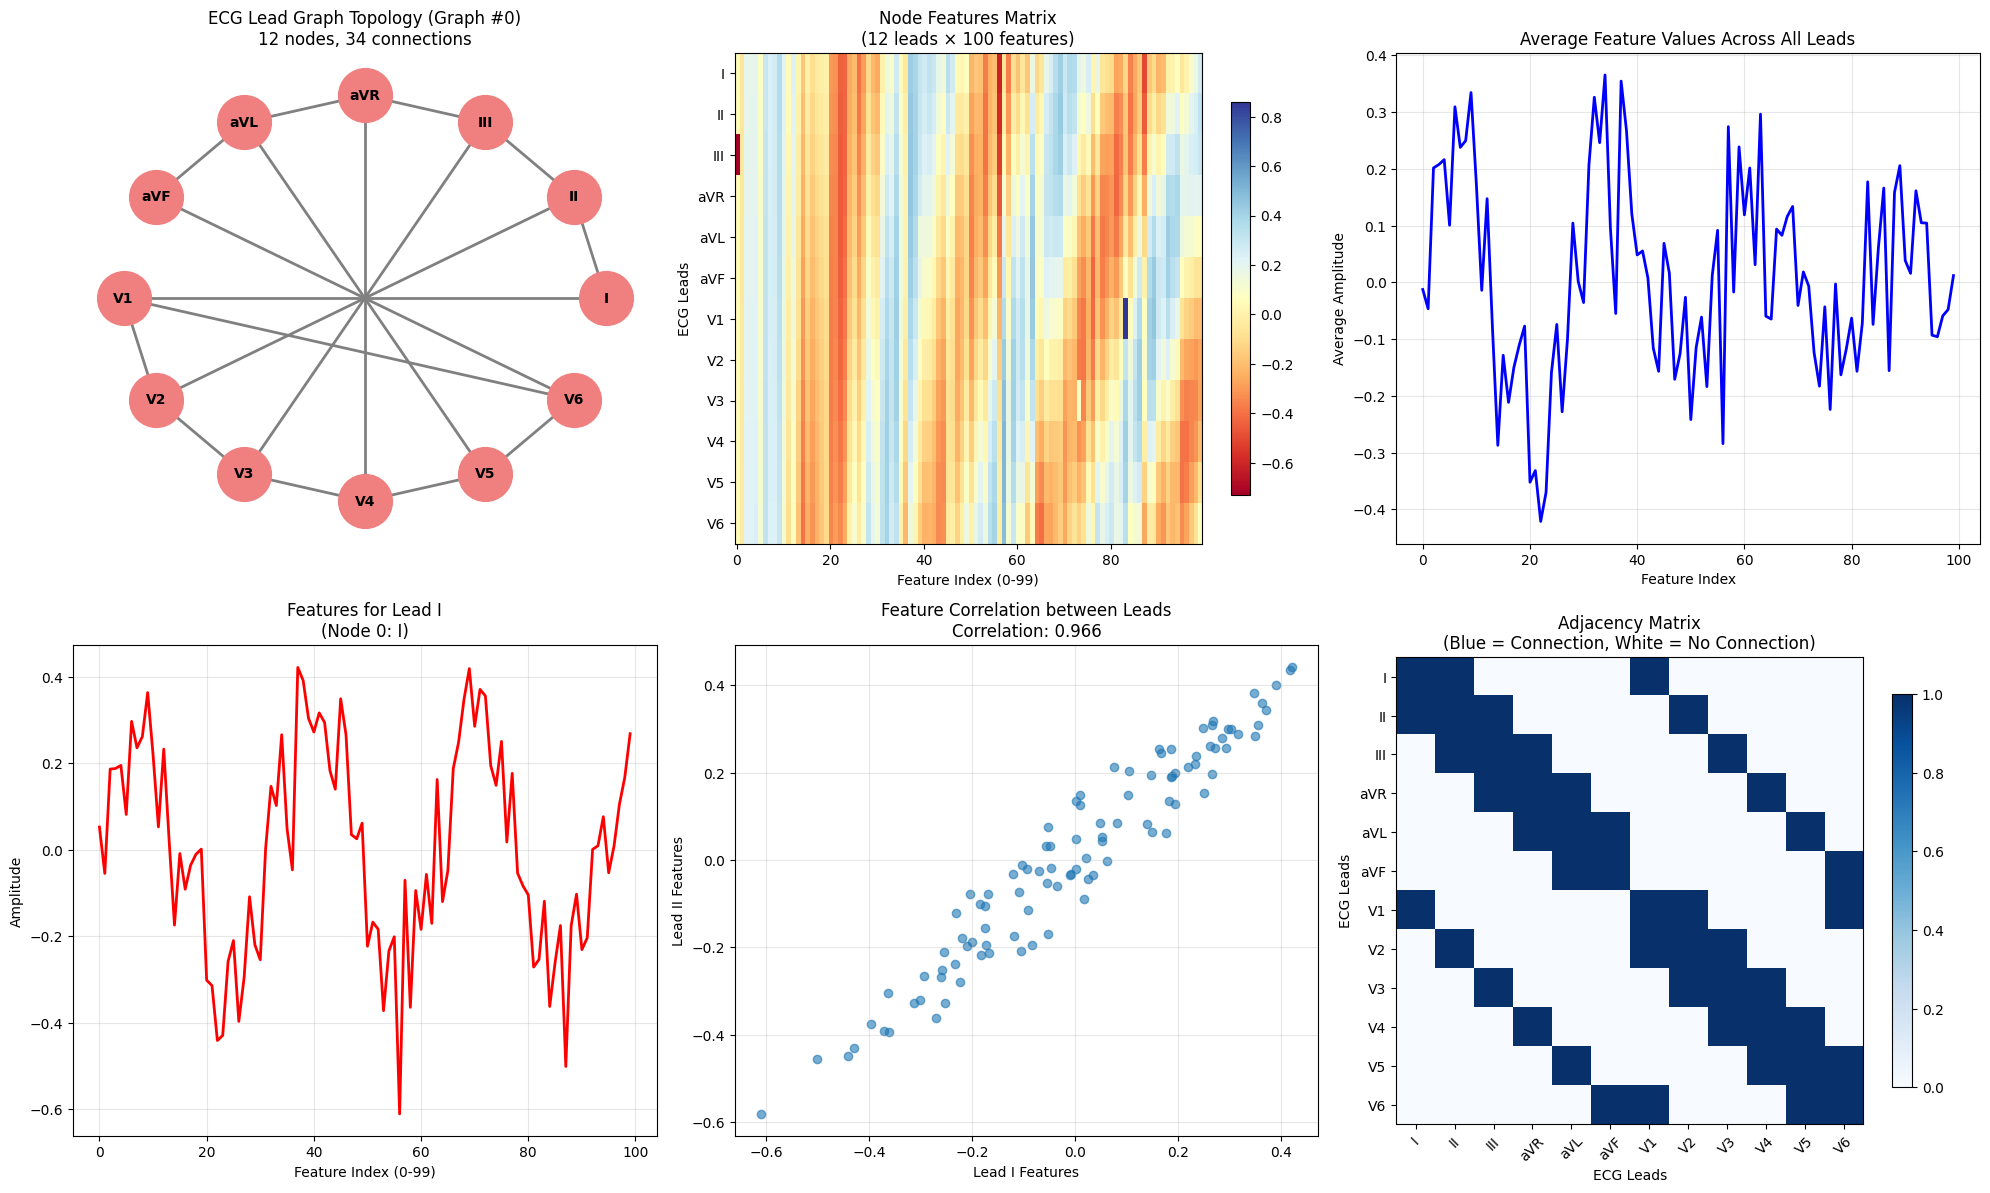


GRAPH STRUCTURE ANALYSIS - GRAPH #0
🔢 NODES (ECG Leads):
   • Total nodes: 12
   • Features per node: 100
   • Lead names: ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

🔗 EDGES (Connections):
   • Total edges: 46
   • Unique connections: 17

📊 FEATURE ANALYSIS:
   • Feature range: [-0.729, 0.860]
   • Mean amplitude: 0.008
   • Std deviation: 0.232

🏷️  LABEL:
   • Label value: 1


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np
import torch
from torch_geometric.data import Data

def visualize_graph_structure(graph_data, graph_index=0, lead_names=None):
    """Visualize the graph structure showing how 100 features are connected"""

    if lead_names is None:
        lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

    fig = plt.figure(figsize=(20, 12))

    # 1. Graph network visualization
    plt.subplot(2, 3, 1)
    G = nx.Graph()

    # Add nodes (ECG leads)
    num_nodes = graph_data.x.shape[0]
    node_labels = {i: lead_names[i] if i < len(lead_names) else f'Lead {i}' for i in range(num_nodes)}
    G.add_nodes_from(range(num_nodes))

    # Add edges (skip self-loops for visualization)
    edges_to_show = []
    for i in range(graph_data.edge_index.shape[1]):
        src, dst = graph_data.edge_index[:, i].tolist()
        if src != dst:  # Skip self-loops
            edges_to_show.append((src, dst))

    G.add_edges_from(edges_to_show)

    # Position nodes in a circular layout to show structure
    pos = nx.circular_layout(G)
    nx.draw(G, pos, labels=node_labels, with_labels=True, node_color='lightcoral',
            node_size=1500, font_size=10, font_weight='bold', edge_color='gray', width=2)
    plt.title(f'ECG Lead Graph Topology (Graph #{graph_index})\n{num_nodes} nodes, {len(edges_to_show)} connections')

    # 2. Node features as heatmap (12 leads × 100 features)
    plt.subplot(2, 3, 2)
    im = plt.imshow(graph_data.x.numpy(), cmap='RdYlBu', aspect='auto', interpolation='nearest')
    plt.colorbar(im, shrink=0.8)
    plt.xlabel('Feature Index (0-99)')
    plt.ylabel('ECG Leads')
    plt.title(f'Node Features Matrix\n({graph_data.x.shape[0]} leads × {graph_data.x.shape[1]} features)')
    plt.yticks(range(min(12, num_nodes)),
               [lead_names[i] if i < len(lead_names) else f'Lead {i}' for i in range(min(12, num_nodes))])

    # 3. Feature distribution across leads
    plt.subplot(2, 3, 3)
    feature_means = torch.mean(graph_data.x, dim=0).numpy()  # Average across leads
    plt.plot(feature_means, linewidth=2, color='blue')
    plt.xlabel('Feature Index')
    plt.ylabel('Average Amplitude')
    plt.title('Average Feature Values Across All Leads')
    plt.grid(True, alpha=0.3)

    # 4. Individual lead feature visualization (Lead I as example)
    plt.subplot(2, 3, 4)
    if num_nodes > 0:
        lead_i_features = graph_data.x[0].numpy()
        plt.plot(lead_i_features, linewidth=2, color='red')
        plt.xlabel('Feature Index (0-99)')
        plt.ylabel('Amplitude')
        plt.title(f'Features for Lead I\n(Node 0: {lead_names[0] if 0 < len(lead_names) else "Lead 0"})')
        plt.grid(True, alpha=0.3)

    # 5. Feature correlation between leads
    plt.subplot(2, 3, 5)
    if graph_data.x.shape[0] >= 2:
        # Correlation between first two leads
        lead1 = graph_data.x[0].numpy()
        lead2 = graph_data.x[1].numpy()
        correlation = np.corrcoef(lead1, lead2)[0, 1]
        plt.scatter(lead1, lead2, alpha=0.6)
        plt.xlabel(f'Lead {lead_names[0] if 0 < len(lead_names) else "0"} Features')
        plt.ylabel(f'Lead {lead_names[1] if 1 < len(lead_names) else "1"} Features')
        plt.title(f'Feature Correlation between Leads\nCorrelation: {correlation:.3f}')
        plt.grid(True, alpha=0.3)

    # 6. Adjacency matrix visualization
    plt.subplot(2, 3, 6)
    adj_matrix = np.zeros((num_nodes, num_nodes))
    for i in range(graph_data.edge_index.shape[1]):
        src, dst = graph_data.edge_index[:, i]
        adj_matrix[src, dst] = 1

    im = plt.imshow(adj_matrix, cmap='Blues', interpolation='nearest')
    plt.colorbar(im, shrink=0.8)
    plt.xlabel('ECG Leads')
    plt.ylabel('ECG Leads')
    plt.title('Adjacency Matrix\n(Blue = Connection, White = No Connection)')
    plt.xticks(range(min(12, num_nodes)),
               [lead_names[i] if i < len(lead_names) else f'{i}' for i in range(min(12, num_nodes))],
               rotation=45)
    plt.yticks(range(min(12, num_nodes)),
               [lead_names[i] if i < len(lead_names) else f'{i}' for i in range(min(12, num_nodes))])

    plt.tight_layout()
    plt.show()

    # Print detailed information
    print(f"\n{'='*60}")
    print(f"GRAPH STRUCTURE ANALYSIS - GRAPH #{graph_index}")
    print(f"{'='*60}")
    print(f"🔢 NODES (ECG Leads):")
    print(f"   • Total nodes: {graph_data.x.shape[0]}")
    print(f"   • Features per node: {graph_data.x.shape[1]}")
    print(f"   • Lead names: {[lead_names[i] if i < len(lead_names) else f'Lead {i}' for i in range(graph_data.x.shape[0])]}")

    print(f"\n🔗 EDGES (Connections):")
    print(f"   • Total edges: {graph_data.edge_index.shape[1]}")
    print(f"   • Unique connections: {len(set(tuple(sorted(edge)) for edge in edges_to_show))}")

    print(f"\n📊 FEATURE ANALYSIS:")
    print(f"   • Feature range: [{torch.min(graph_data.x):.3f}, {torch.max(graph_data.x):.3f}]")
    print(f"   • Mean amplitude: {torch.mean(graph_data.x):.3f}")
    print(f"   • Std deviation: {torch.std(graph_data.x):.3f}")

    if hasattr(graph_data, 'y') and graph_data.y is not None:
        print(f"\n🏷️  LABEL:")
        print(f"   • Label value: {graph_data.y.item() if graph_data.y.dim() == 0 else graph_data.y}")

def visualize_multiple_graphs_structure(graph_data_list, indices=[0, 1], lead_names=None):
    """Visualize structure of multiple graphs from graph_data_list"""

    if lead_names is None:
        lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

    print("GRAPH STRUCTURE VISUALIZATION")
    print("="*50)

    for idx in indices:
        if idx < len(graph_data_list):
            visualize_graph_structure(graph_data_list[idx], idx, lead_names)
            print("\n" + "-"*80 + "\n")
        else:
            print(f"Index {idx} is out of range. Dataset has {len(graph_data_list)} graphs.")

def visualize_feature_distributions(graph_data_list, num_graphs=5):
    """Visualize how features are distributed across the dataset"""

    if len(graph_data_list) == 0:
        print("No graph data to visualize!")
        return

    print("FEATURE DISTRIBUTION ANALYSIS")
    print("="*40)

    # Collect features from first few graphs
    all_features = []
    for i in range(min(num_graphs, len(graph_data_list))):
        graph = graph_data_list[i]
        all_features.append(graph.x.numpy())

    all_features = np.concatenate(all_features, axis=0)  # Shape: (num_leads*num_graphs, 100)

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Feature value distribution
    axes[0, 0].hist(all_features.flatten(), bins=50, alpha=0.7, color='skyblue')
    axes[0, 0].set_xlabel('Feature Value')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Distribution of All Feature Values')
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Mean feature values across all samples
    mean_features = np.mean(all_features, axis=0)
    axes[0, 1].plot(mean_features, linewidth=2, color='red')
    axes[0, 1].set_xlabel('Feature Index')
    axes[0, 1].set_ylabel('Mean Value')
    axes[0, 1].set_title('Mean Feature Values (Across All Leads/Samples)')
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Feature variance across all samples
    std_features = np.std(all_features, axis=0)
    axes[1, 0].plot(std_features, linewidth=2, color='green')
    axes[1, 0].set_xlabel('Feature Index')
    axes[1, 0].set_ylabel('Standard Deviation')
    axes[1, 0].set_title('Feature Variance (Across All Leads/Samples)')
    axes[1, 0].grid(True, alpha=0.3)

    # 4. Feature correlation matrix (first 10 features)
    corr_matrix = np.corrcoef(all_features[:, :10].T)
    im = axes[1, 1].imshow(corr_matrix, cmap='RdYlBu', vmin=-1, vmax=1)
    plt.colorbar(im, ax=axes[1, 1])
    axes[1, 1].set_xlabel('Feature Index')
    axes[1, 1].set_ylabel('Feature Index')
    axes[1, 1].set_title('Feature Correlation Matrix (First 10 Features)')

    plt.tight_layout()
    plt.show()

    print(f"Analyzed {min(num_graphs, len(graph_data_list))} graphs")
    print(f"Total features analyzed: {all_features.shape[0]} leads × 100 features = {all_features.shape[0] * 100} values")
    print(f"Feature value range: [{np.min(all_features):.3f}, {np.max(all_features):.3f}]")
    print(f"Overall mean: {np.mean(all_features):.3f}")
    print(f"Overall std: {np.std(all_features):.3f}")

# Usage examples:
print("Visualizing graph structure to understand 100 features representation...")

# Visualize the structure of the first graph
if len(graph_data_list) > 0:
    visualize_graph_structure(graph_data_list[0], graph_index=0)

# Visualize multiple graphs
# visualize_multiple_graphs_structure(graph_data_list, indices=[0, 1, 2])

# Visualize feature distributions across the dataset
# visualize_feature_distributions(graph_data_list, num_graphs=5)